# 量子機械学習とTTN
量子機械学習のモデルとしてTree Tensor Networkを見てみます。

## 今回学ぶこと
1. TTNモデル
2. 最適化計算

## Blueqatのインストール
pipからBlueqatをインストールします

In [2]:
!pip install blueqat

dwave-cloud-client 0.7.2 has requirement click>=7.0, but you'll have click 6.7 which is incompatible.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


今回作るのはTTNと呼ばれるモデルです。量子回路は、

```
|0> --*--
      |
|0> --*----*--
           |
|0> --*--  |
      |    |
|0> --*----*--[M]
```

全体的に木構造をとる形状をしています。今回の回路は1量子ビットの回転ゲートと2量子ビットゲートのCXを使います。より詳しくは、

```
|0> --Rx-Ry-Rz--*--
                |
|0> --Rx-Ry-Rz--X--Rx-Ry-Rz--*--
                             |
|0> --Rx-Ry-Rz--*--          |
                |            |
|0> --Rx-Ry-Rz--X--Rx-Ry-Rz--X--[M]
```

Rx,Ry,RzゲートとCXを配置します。

まずツールを読み込みます。

In [3]:
from blueqat import Circuit
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

ハイパーパラメータ類の設定をします。

In [33]:
np.random.seed(45)

#最適化計算の回数
nsteps = 5000

#最適化する量子回路のパラメータの数
nparams = 18

#数値微分の細かさ
h = 0.01

#学習率
e = 0.01

#初期のパラメータ
ainit = [np.random.rand()*np.pi*2 for i in range(nparams)]

#結果格納用のlist
arr = []

#1なら訓練、2なら推論
mode = 1

早速モデルを作ります。木構造のモデルを採用しました。また、今回は学習するinputを選べるようにしました。

In [37]:
def meraZ(a,ran,mode=1):
    
    #入力回路
    init = [Circuit(4).x[0,1],Circuit(4).x[2,3],Circuit(4).x[0],Circuit(4).x[1],Circuit(4).x[2],Circuit(4).x[0,2]]
    #ターゲットラベル
    target = [1,1,-1,-1,-1,1]
   
    #回路を作り始めます
    u = init[ran]
    u.rx(a[0])[0].ry(a[1])[0].rz(a[2])[0]
    u.rx(a[3])[1].ry(a[4])[1].rz(a[5])[1]
    u.rx(a[6])[2].ry(a[7])[2].rz(a[8])[2]
    u.rx(a[9])[3].ry(a[10])[3].rz(a[11])[3]
    u.cx[0,1].cx[2,3]
    u.rx(a[12])[1].ry(a[13])[1].rz(a[14])[1]
    u.rx(a[15])[3].ry(a[16])[3].rz(a[17])[3]
    u.cx[1,3]
    
    #状態ベクトルをとります。
    full = u.run()
    expt = sum(np.abs(full[:8])**2)-sum(np.abs(full[8:])**2)
    
    #full = u.m[3].run(shots=nshots)
    #expt = (full['0000'] - full['0001'])/nshots
    
    if(mode ==1):
        #期待値とラベルの誤差を返します
        return (expt - target[ran])**2
    else:
        return expt

早速開始です。毎回の勾配の計算時にデータをランダムで0から3まで選び最適化をかけます。

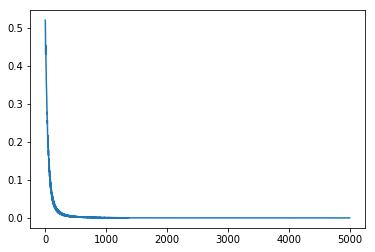

80.89450860023499


In [35]:
start = time.time()

for i in range(nsteps):
    it = np.random.randint(0,3)
    
    loss = meraZ(ainit,it,mode)
    arr.append(loss)
    atemp = [0 for i in range(nparams)]
    
    for j in range(nparams):
        aa = ainit.copy()
        aa[j] += h
        atemp[j] = ainit[j] - e*(meraZ(aa,it,mode) - loss)/h

    ainit = atemp

plt.plot(arr)
plt.show()
print(time.time() - start)

うまく収束したのでチェックしてみたいと思います。

In [42]:
meraZ(ainit,4,mode=2)

-0.9932513354175622

In [43]:
meraZ(ainit,5,mode=2)

0.9963006935017055